## Regressor Model evaluation 

For modelling the travel time it is necessary to evaluate the possible models and comes up with a best-fit model for the data giving accurate predictions. Few of the possible models 1. `Linear regressor`, 2. `Random Forest`, 3. `KNN` are tested for accuracy. After testing the train and test data accuracy the models were also given a sample of 100 points to evaluate whether it comes within the google predicted travel time range for that time. The RMSE value of the model prediction from the google average was also calculated for evaluating the best fit model with source and destination samples anywhere within the geometry

After evaluating the three models we got into the conclution that the `linear regressor model` best suits the travel time prediction, which gives a accuracy of 80 percent when compared to the google range of travel time pedication.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
import os
import math

The sample data from our uber daily data model is loaded

In [2]:
data_folder = os.path.join('data', 'train')
train_filepath = os.path.join(data_folder,'samples.csv')
samples= pd.read_csv(train_filepath)
samples.head()

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,time_period,dow,src_lon,src_lat,dst_lon,dst_lat,distance
0,166,14,3,5,16,19,4267.51,584.94,4228.03,1.15,4,3,77.680209,12.922874,77.622411,13.056525,24164.0
1,132,78,1,30,19,0,2038.28,699.54,1929.37,1.39,5,3,77.563776,12.958184,77.656791,12.976504,12983.0
2,182,96,1,17,19,0,2988.72,843.30,2870.15,1.33,5,4,77.622070,12.865000,77.577098,12.970688,16205.8
3,84,128,3,18,16,19,1347.08,207.92,1331.40,1.16,4,2,77.599931,12.995107,77.551941,12.960545,8585.2
4,166,136,2,22,19,0,2555.25,558.56,2498.95,1.23,5,5,77.680209,12.922874,77.567874,12.948692,16902.8


In [3]:
ref_path = os.path.join('data','googlemaps','googlemaps_traveltimes.csv')
reference_data=pd.read_csv(ref_path)
reference_data['goog_avg']= reference_data.apply(lambda x : (x['goog_min']+x['goog_max'])/2,axis=1)
reference_data.head()

,sourceid,dstid,month,day,time_period,dow,src_lon,src_lat,dst_lon,dst_lat,distance,goog_distance,goog_min,goog_max,goog_avg
0,91,184,2,19,2,2,77.637890,12.930561,77.590090,12.888096,9686.2,10700,22,40,31.0
1,91,184,2,23,1,6,77.644817,12.944129,77.586162,12.885430,14531.8,15700,30,40,35.0
2,91,165,1,6,1,0,77.643652,12.941535,77.761146,12.935575,16056.7,16200,30,40,35.0
3,10,165,2,3,5,0,77.655367,12.950985,77.713831,12.937901,10362.1,11000,20,35,27.5
4,10,165,3,6,4,4,77.658390,12.949876,77.716294,12.927034,8051.9,10300,24,40,32.0


In [27]:
sel_input=['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance']

In [28]:
x = samples[sel_input].values
y = samples['geometric_mean_travel_time']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

In [31]:
def predict_time(row):
    input = row[['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance']]
    return round(model.predict([input])[0]/60)

In [32]:
def rmse_calc():
    reference_data['predicted'] = reference_data.apply(predict_time, axis=1)
    results = reference_data[['sourceid', 'dstid', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat','distance', 'goog_distance', 'goog_min', 'goog_max','goog_avg','predicted']].copy()
    results['within_range'] = np.where((results['predicted'] <= results['goog_max'])
        & (results['predicted'] >= results['goog_min']), 'Y', 'N')
    percent=results['within_range'].value_counts('Y')[0]
    percent_within.append(percent)
    error = math.sqrt(mean_squared_error(reference_data['goog_avg'],reference_data['predicted'])) #calculate rmse
    RMSE.append(error)
    return results


## Linear Regressor Model


The data set contains categorical variable in case of 'time_period' and 'dow' and hence these are one_hot_encoded since these categorical values has no significance for linear model. 

In [33]:
sel_input=['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance']
cat_input=['time_period','dow']
num_input= list(set(sel_input)-set(cat_ip))

In [34]:
category_Trans= ColumnTransformer([('encoder',OneHotEncoder(categories='auto'),[sel_input.index(i) for i in cat_input]),
                                   ('scaler',StandardScaler(),[sel_input.index(i) for i in num_input])])

In [35]:
model = Pipeline(steps=[('ct',category_Trans),('model',LinearRegression())])

In [36]:
model.fit(x_train,y_train)
model.score(x_train,y_train)

0.7439553264850376

In [37]:
RMSE=[]
percent_within=[]
LR=pd.DataFrame()
#model = LinearRegression()  
#model.fit(x_train, y_train)
results=rmse_calc()
LR['Percent_within']=percent_within
LR['RMSE']=RMSE
LR['train_score']=model.score(x_train,y_train)
LR['test_scre']=model.score(x_test,y_test)
LR



,Percent_within,RMSE,train_score,test_scre
0,0.8,6.945682,0.743955,0.743688


#### Linear model without one hot encoding

In [38]:
RMSE=[]
percent_within=[]
LR=pd.DataFrame()
model = Pipeline(steps=[('scaler',StandardScaler()),('model',LinearRegression())])
model.fit(x_train,y_train)
results=rmse_calc()
LR['Percent_within']=percent_within
LR['RMSE']=RMSE
LR['train_score']=model.score(x_train,y_train)
LR['test_scre']=model.score(x_test,y_test)
print(LR)
results

   Percent_within      RMSE  train_score  test_scre
0             0.8  8.007028     0.681878   0.680849


,sourceid,dstid,src_lon,src_lat,dst_lon,dst_lat,distance,goog_distance,goog_min,goog_max,goog_avg,predicted,within_range
0,91,184,77.637890,12.930561,77.590090,12.888096,9686.2,10700,22,40,31.0,27,Y
1,91,184,77.644817,12.944129,77.586162,12.885430,14531.8,15700,30,40,35.0,33,Y
2,91,165,77.643652,12.941535,77.761146,12.935575,16056.7,16200,30,40,35.0,40,Y
3,10,165,77.655367,12.950985,77.713831,12.937901,10362.1,11000,20,35,27.5,35,Y
4,10,165,77.658390,12.949876,77.716294,12.927034,8051.9,10300,24,40,32.0,25,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,185,49,77.556457,12.861758,77.572991,13.007320,20097.0,20300,40,50,45.0,44,Y
96,159,49,77.588550,12.909991,77.570795,12.997582,12067.3,11900,22,40,31.0,35,Y
97,76,178,77.648405,13.006604,77.661723,12.881504,20443.1,24000,45,80,62.5,51,Y
98,193,178,77.597410,12.915178,77.650824,12.889310,8032.5,8000,18,35,26.5,22,Y


## MLP Regressor

In [21]:
RMSE=[]
percent_within=[]
model = Pipeline(steps=[('scaler',StandardScaler()),('model',MLPRegressor(random_state=1, max_iter=200))])
model.fit(x_train, y_train)
results=rmse_calc()
print('RMSE =',RMSE)
print('Percentage with google range =',percent_within)
results.head()

RMSE = [10.870717547613864]
Percentage with google range = [0.62]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,sourceid,dstid,src_lon,src_lat,dst_lon,dst_lat,distance,goog_distance,goog_min,goog_max,goog_avg,predicted,within_range
0,91,184,77.637890,12.930561,77.590090,12.888096,9686.2,10700,22,40,31.0,29,Y
1,91,184,77.644817,12.944129,77.586162,12.885430,14531.8,15700,30,40,35.0,20,N
2,91,165,77.643652,12.941535,77.761146,12.935575,16056.7,16200,30,40,35.0,21,N
3,10,165,77.655367,12.950985,77.713831,12.937901,10362.1,11000,20,35,27.5,21,Y
4,10,165,77.658390,12.949876,77.716294,12.927034,8051.9,10300,24,40,32.0,21,N


## Random Forest Model

### Random Forest with one hot encoding

In [ ]:
Range=range(5,20)
Random_Forest=pd.DataFrame()
Random_Forest['n']=Range
RMSE=[]
percent_within=[]
Train_score=[]
Test_score=[]
for k in Range:
    model = Pipeline(steps=[('ct',category_Trans),('model',RandomForestRegressor(n_estimators = k, random_state = 1))])#model= RandomForestRegressor(n_estimators = k, random_state = 1)
    model.fit(x_train, y_train)
    results=rmse_calc()
    Train_score.append(model.score(x_train, y_train))
    Test_score.append(model.score(x_test, y_test))
Random_Forest['percent_within']=percent_within
Random_Forest['RMSE']=RMSE
Random_Forest['Train_score']=Train_score
Random_Forest['Test_score']=Test_score
Random_Forest

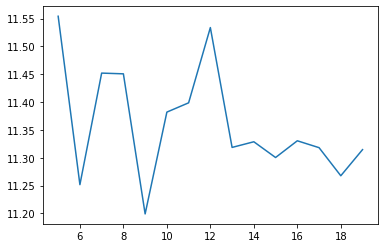

In [23]:
plt.plot(Random_Forest['n'],Random_Forest['RMSE'])

In [94]:
all_cat=list(model.named_steps['ct'].transformers_[0][1].get_feature_names(cat_input))
all_features= all_cat + num_input

<BarContainer object of 17 artists>

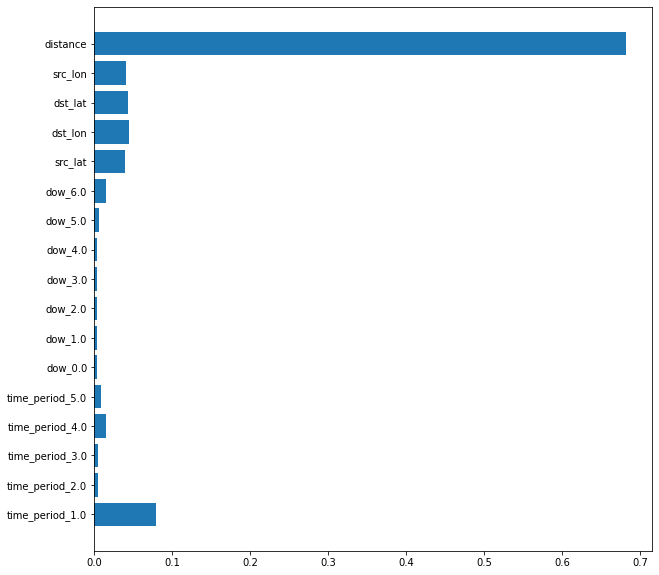

In [97]:
# get importance
importance = model.steps[1][1].feature_importances_
plt.figure(figsize=(10,10))
plt.barh(all_features,importance)

### Random Forest without One hot encoding

In [100]:
Range=range(5,20)
Random_Forest=pd.DataFrame()
Random_Forest['n']=Range
RMSE=[]
percent_within=[]
Train_score=[]
Test_score=[]
for k in Range:
    model = Pipeline(steps=[('scaler',StandardScaler()),('model',RandomForestRegressor(n_estimators = k, random_state = 1))])
    model.fit(x_train,y_train)
    results=rmse_calc()
    Train_score.append(model.score(x_train, y_train))
    Test_score.append(model.score(x_test, y_test))
Random_Forest['percent_within']=percent_within
Random_Forest['RMSE']=RMSE
Random_Forest['Train_score']=Train_score
Random_Forest['Test_score']=Test_score
Random_Forest
    

,n,percent_within,RMSE,Train_score,Test_score
0,5,0.58,12.198463,0.972401,0.898066
1,6,0.60,12.110017,0.973809,0.900496
2,7,0.57,11.994686,0.974824,0.902195
3,8,0.55,11.772956,0.975607,0.903513
4,9,0.54,11.797139,0.976188,0.904293
5,10,0.54,11.731262,0.976677,0.905158
6,11,0.54,11.735949,0.977068,0.905798
7,12,0.55,11.636258,0.977415,0.906221
8,13,0.54,11.632390,0.977703,0.906617
9,14,0.53,11.820850,0.977939,0.907043


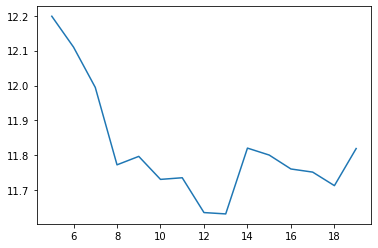

In [101]:
plt.plot(Random_Forest['n'],Random_Forest['RMSE'])

### Analysing feature importances in Randomforest Model

In [102]:
all_features=sel_input

<BarContainer object of 7 artists>

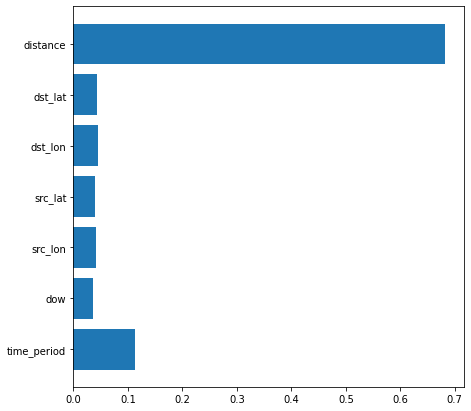

In [104]:
# get importance
importance = model.steps[1][1].feature_importances_
plt.figure(figsize=(7,7))
plt.barh(all_features,importance)

## K Nearest Neighbor Model

### With one hot encoding

In [28]:
Range=range(1,20)
KNN=pd.DataFrame()
KNN['n']=Range
RMSE=[]
percent_within=[]
Train_score=[]
Test_score=[]
for k in Range:
    model = Pipeline(steps=[('ct',category_Trans),('model',KNeighborsRegressor(n_neighbors = k))])#model= RandomForestRegressor(n_estimators = k, random_state = 1)
    model.fit(x_train, y_train)
    results=rmse_calc()
    #Train_score.append(model.score(x_train, y_train))
    #Test_score.append(model.score(x_test, y_test))
KNN['percent_within']=percent_within
KNN['RMSE']=RMSE
#KNN['Train_score']=Train_score
#KNN['Test_score']=Test_score
KNN

,n,percent_within,RMSE
0,1,0.54,14.648635
1,2,0.52,13.429538
2,3,0.55,13.159122
3,4,0.50,12.636950
4,5,0.54,12.345141
5,6,0.55,12.048755
6,7,0.56,11.752553
7,8,0.57,11.550433
8,9,0.56,11.509670
9,10,0.55,11.245555


### KNN without one hot encoding

In [29]:
Range=range(1,20)
KNN=pd.DataFrame()
KNN['n']=Range
RMSE=[]
percent_within=[]
Train_score=[]
Test_score=[]
for k in Range:
    model = Pipeline(steps=[('scaler',StandardScaler()),('model',KNeighborsRegressor(n_neighbors = k))])
    model.fit(x_train, y_train)
    results=rmse_calc()
    #Train_score.append(model.score(x_train, y_train))
    #Test_score.append(model.score(x_test, y_test))    
KNN['percent_within']=percent_within
KNN['RMSE']=RMSE
#KNN['Train_score']=Train_score
#KNN['Test_score']=Test_score
KNN

,n,percent_within,RMSE
0,1,0.52,16.076147
1,2,0.56,13.337260
2,3,0.53,12.382346
3,4,0.57,12.093490
4,5,0.55,11.997604
5,6,0.57,11.724867
6,7,0.58,11.436892
7,8,0.58,11.338540
8,9,0.56,11.228201
9,10,0.59,11.153587


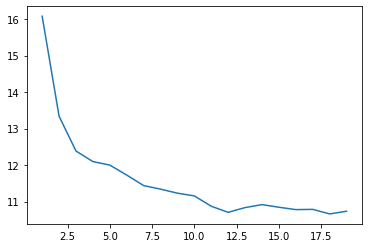

In [30]:
plt.plot(KNN['n'],KNN['RMSE'])